# Criação de modelos de regressão para previsão de votos de candidatos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## 1. Análise dos dados 

### 1.1 Leitura dos dados

In [2]:
train_data = pd.read_csv("data/election_2006_a_2010.csv")
test_data = pd.read_csv("data/election_2014.csv")

# load the dataset as a pandas data frame
df_train_data = pd.DataFrame(train_data)
df_test_data = pd.DataFrame(test_data)

frames = [df_train_data, df_test_data]
df_data = pd.concat(frames)

In [3]:
df_data.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


### 1.2 Pré-processamento dos dados

- Transformação das features numéricas enviesadas usando log(feature + 1), a fim de normalizar a distribuição dos valores;
- Tratamento das features numéricas com valores ausentes (NaN's);
- Transformação das variáveis categóricas.

#### Enviesamento de features numéricas

Através dos histogramas abaixo vemos que as variáveis analisadas precisam de normalização, porque a distribuição dos seus valores não está igual.

In [4]:
# function to plot a histogram of each variable
def plot_histogram(feature):
    # log (feature + 1) because of features with values 0
    feature = pd.DataFrame({"1. " + feature: df_data[feature], "2. log(" + feature + ")": np.log1p(df_data[feature])})
    feature.hist()

# function to transform skewed variables using log(feature + 1)
def transform_skewed_var(feature):
    df_data[feature] = np.log1p(df_data[feature])

/home/veruska/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.
/home/veruska/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log1p
  if __name__ == '__main__':


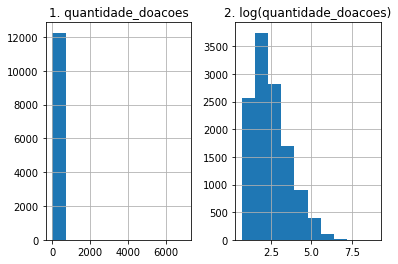

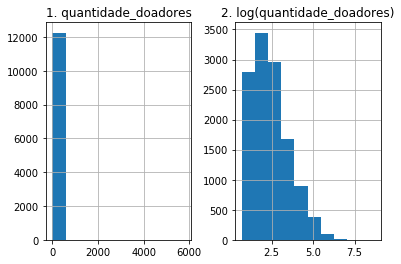

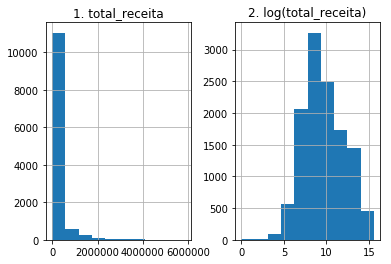

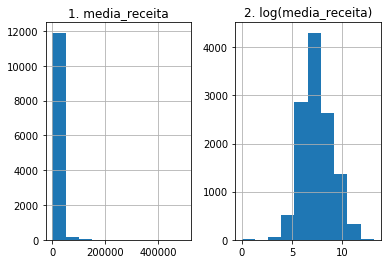

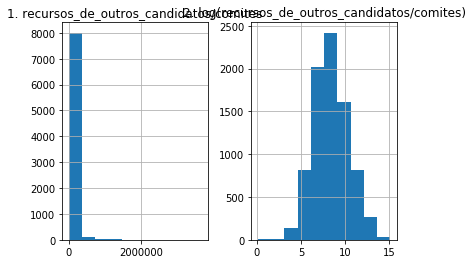

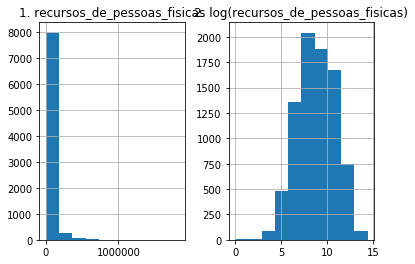

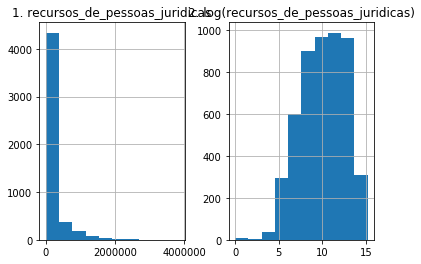

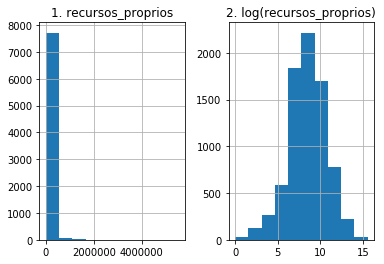

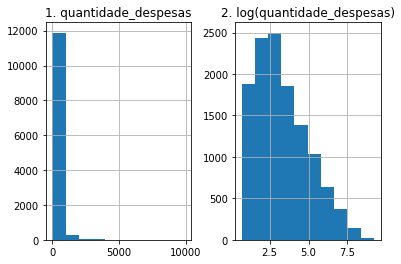

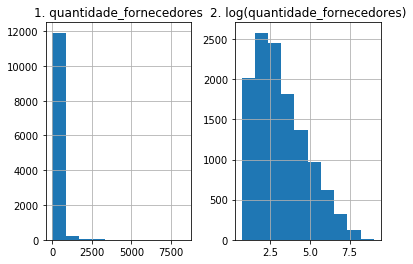

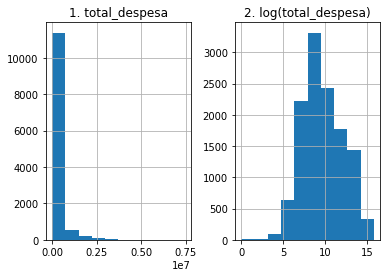

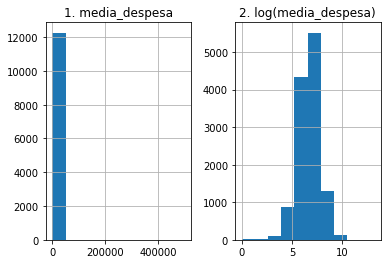

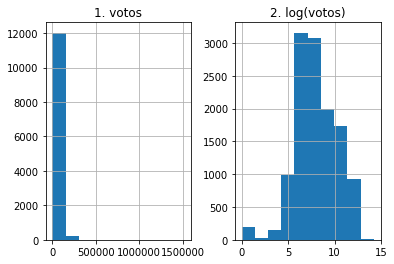

In [5]:
columns = "quantidade_doacoes quantidade_doadores total_receita media_receita recursos_de_outros_candidatos/comites recursos_de_pessoas_fisicas recursos_de_pessoas_juridicas recursos_proprios quantidade_despesas quantidade_fornecedores total_despesa media_despesa votos".split()

for feature in columns:
    plot_histogram(feature)
    transform_skewed_var(feature)    

#### Features com valores numéricos ausentes (NaN) 

Abaixo veremos quais as variáveis com valores ausentes (NaN).

In [6]:
df_data.isnull().any()

ano                                      False
sequencial_candidato                     False
nome                                     False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                             True
media_receita                             True
recursos_de_outros_candidatos/comites     True
recursos_de_pessoas_fisicas               True
recursos_de_pessoas_juridicas             True
recursos_proprios                         True
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao     

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12266 entries, 0 to 4935
Data columns (total 23 columns):
ano                                      12266 non-null int64
sequencial_candidato                     12266 non-null int64
nome                                     12266 non-null object
uf                                       12266 non-null object
partido                                  12266 non-null object
quantidade_doacoes                       12266 non-null float64
quantidade_doadores                      12266 non-null float64
total_receita                            12105 non-null float64
media_receita                            12105 non-null float64
recursos_de_outros_candidatos/comites    8131 non-null float64
recursos_de_pessoas_fisicas              8374 non-null float64
recursos_de_pessoas_juridicas            5068 non-null float64
recursos_proprios                        7802 non-null float64
quantidade_despesas                      12266 non-null float64
quantid

Há 6 variáveis com valores ausentes. Para substituí-los, os dados serão agrupados por anos e os valores ausentes dessas variáveis serão substituídos pela mediana dos valores da respectiva variável.

Optou por excluir as variáveis **nome** e **sequencial_candidato**, porque elas não influenciam na quantidade de votos e possui muitos valores categóricos, o que prejudicaria os modelos de previsão.

In [8]:
print(df_data.shape)

#removing collumns
df_data = df_data.drop(["nome", "sequencial_candidato"], 1)


#grouping by year and filling NA's with the median of the column
numeric_feats = df_data.dtypes[df_data.dtypes != "object"].index
df_data[numeric_feats] = df_data.groupby(['ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

print(df_data.shape)
df_data.isnull().any()

(12266, 23)
(12266, 21)


ano                                      False
uf                                       False
partido                                  False
quantidade_doacoes                       False
quantidade_doadores                      False
total_receita                            False
media_receita                            False
recursos_de_outros_candidatos/comites    False
recursos_de_pessoas_fisicas              False
recursos_de_pessoas_juridicas            False
recursos_proprios                        False
quantidade_despesas                      False
quantidade_fornecedores                  False
total_despesa                            False
media_despesa                            False
cargo                                    False
sexo                                     False
grau                                     False
estado_civil                             False
ocupacao                                 False
votos                                    False
dtype: bool

#### Tranformação das variáveis categóricas

As variáveis categóricas presentes nos dados, como **ocupação** e **estado_civil**, serão transformadas em variáveis numéricas, a fim de permitir a sua utilização nos modelos de regressão logo a seguir.

In [9]:
df_data = pd.get_dummies(df_data)

df_data.head(10)

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,...,ocupacao_TÉCNICO DE QUÍMICA,ocupacao_TÉCNICO EM AGRONOMIA E AGRIMENSURA,ocupacao_TÉCNICO EM EDIFICAÇÕES,ocupacao_TÉCNICO EM INFORMÁTICA,ocupacao_VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA,"ocupacao_VENDEDOR PRACISTA, REPRESENTANTE, CAIXEIRO-VIAJANTE E ASSEMELHADOS",ocupacao_VEREADOR,ocupacao_VETERINÁRIO,ocupacao_VIGILANTE,ocupacao_ZOOTECNISTA
0,2006,1.945910,1.945910,9.717218,7.925760,7.937732,9.105091,8.748464,7.170888,2.708050,...,0,0,0,0,0,0,1,0,0,0
1,2006,2.639057,2.639057,10.035699,7.471276,8.798757,9.615872,6.908755,5.308268,3.218876,...,0,0,0,0,0,0,0,0,0,0
2,2006,2.890372,2.833213,11.905790,9.133303,7.719130,10.438547,11.038461,10.993748,4.820282,...,0,0,0,0,0,0,0,0,0,0
3,2006,1.945910,1.945910,8.007074,6.216979,7.937732,7.048386,7.004991,6.621406,2.197225,...,0,0,0,0,0,0,0,0,0,0
4,2006,3.891820,3.891820,9.233666,7.274180,7.937732,10.837206,9.913480,11.141035,4.897840,...,0,0,0,0,0,0,0,0,0,0
5,2006,1.945910,1.945910,7.479983,5.691041,7.937732,8.987322,9.913480,7.479983,2.302585,...,0,0,0,0,0,0,0,0,0,0
6,2006,2.708050,2.079442,6.548219,4.610868,7.937732,7.116394,9.913480,8.395138,2.890372,...,0,0,0,0,0,0,0,0,0,0
7,2006,1.098612,1.098612,11.156265,10.463132,7.937732,8.987322,9.913480,11.156265,5.808142,...,0,0,0,0,0,0,0,0,0,0
8,2006,1.098612,1.098612,8.710455,8.017472,8.710455,8.987322,9.913480,8.395138,2.397895,...,0,0,0,0,0,0,0,0,0,0
9,2006,4.234107,4.189655,11.569440,7.395657,9.167015,10.987734,10.165890,9.711176,4.234107,...,0,0,0,0,0,0,0,0,0,0


### 1.3 Divisão dos dados em treinamento, validação e teste

Abaixo, o conjunto de dados utilizado será particionado em treino, para servir para a criação dos modelos de regressão, em validação, que será usado para avaliar a qualidade do modelo e em teste, que servirá para avaliar as predições do modelo para dados ainda não vistos por ele.

In [10]:
data_train = df_data.loc[df_data["ano"] == 2006]
y_train = data_train.votos
X_train = data_train.drop("votos", 1)
print(X_train.shape)
print(y_train.shape)

data_validation = df_data.loc[df_data["ano"] == 2010]
y_validation = data_validation.votos
X_validation = data_validation.drop("votos", 1)
print(X_validation.shape)
print(y_validation.shape)

data_test = df_data.loc[df_data["ano"] == 2014]
y_test = data_test.votos
X_test = data_test.drop("votos", 1)
print(X_test.shape)
print(y_test.shape)

#data of 2006 and 2010 together
data_2006_2010 = df_data.loc[df_data["ano"] != 2014]
y_train_2006_2010 = data_2006_2010.votos
X_train_2006_2010 = data_2006_2010.drop("votos", 1)
print(X_train_2006_2010.shape)
print(y_train_2006_2010.shape)

(3388, 283)
(3388,)
(3942, 283)
(3942,)
(4936, 283)
(4936,)
(7330, 283)
(7330,)


## 2. Implementação dos Modelos de Regressão

Nesta seção, implementaremos os modelos de regressão que irão prever a quantidade de votos de um candidato. Dividiremos este processo nas seguintes etapas, para cada modelo:
- Implementação do modelo.
- Ajuste dos parâmetros com cross-validation.
- Avaliação dos modelos com RMSE, R² e resíduos.
- Treinamento com mais dados do modelo com os melhores parâmetros.

#### Funções auxiliares

In [11]:
# function to train the model and to calculate the RMSE with cross validation
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

In [12]:
# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")

In [13]:
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

In [14]:
# function to print the coefficients of the model
def print_coefficients(model):
    w = list(model.coef_)
    # Parameters must be in reverse order because the poly function 
    w.reverse()
    print (np.poly1d(w) + model.intercept_) 

In [15]:
# function to train the model and to return the score
def train_model(model, print_coef):
    model.fit(X_train, y_train)
    if (print_coef):
        print_coefficients(model)
    
    score = model.score(X_validation, y_validation)
    return score

In [16]:
# function to train the model and to return the score and the rmse with specific dataset
def train_model_2014(model):
    model.fit(X_train_2006_2010, y_train_2006_2010)
    
    score = model.score(X_test, y_test)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return score, rmse

In [17]:
# function to plot the residual vs predictions values of the model
def plot_res_vs_pred(model):
    y_pred = model.predict(X_validation)
    res = y_validation - y_pred
    
    matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
    plt.plot(y_pred, res, 'k.', color='blue')
    plt.axhline(y = 0., color = 'r', linestyle = '-')
    plt.xlabel("Predictions")
    plt.ylabel("Residuals")

### 2.1 Modelo Sem Regularização

#### Implementando o modelo de regressão linear múltipla

In [18]:
model_reglinear = LinearRegression().fit(X_train, y_train)
print("Score = {0}".format(model_reglinear.score(X_validation, y_validation)))

predictions = model_reglinear.predict(X_validation)
print("RMSE = {0}".format(np.sqrt(mean_squared_error(y_validation, predictions))))

Score = -3.36529690299e+18
RMSE = 3724035476.87


### 2.2 Modelo Ridge

Ridge é um modelo de regressão no qual sua função de perda ($L$) contém outro elemento que deve ser minimizado também, além da diferença entre os valores previstos e os valores reais. Este outro elemento é a magnitude dos parâmetros estimados para cada variável, então, quanto menor eles, mais simples o modelo e menor a chance de overfitting. Por isso, o $\alpha$ é um escalar que deve ser aprendido, a fim de encontrar o melhor valor que se encaixa aos dados, como será feito mais a frente.

$$L = ∑( Ŷ_{i}– Y_{i})² + \alpha∑ β²$$

#### Implementando o modelo de regressão Ridge

In [19]:
model_ridge = Ridge()
train_model(model_ridge, True)

         282          281          280          279          278
-0.1422 x   + 0.1243 x   + 0.4128 x   + 0.4746 x   - 0.1082 x  
           277          276          275          274          272
 + 0.2606 x   + 0.1561 x   + 0.2955 x   - 0.2628 x   - 0.2523 x  
           271          269          268          267          266
 - 0.3604 x   + 0.3064 x   - 0.5057 x   + 0.1218 x   + 0.3548 x  
           265          263          262          261          256
 + 0.2142 x   + 0.2592 x   - 0.1233 x   - 0.6119 x   - 0.9372 x  
           255          253          252          251          250
 + 0.5971 x   - 0.2479 x   - 0.6492 x   + 0.2166 x   + 0.4912 x  
            249         248           247          246          245
 + 0.04699 x   - 0.436 x   + 0.02064 x   - 0.1549 x   - 0.2356 x  
            244          243          241          239          237
 - 0.04378 x   - 0.2388 x   - 0.4208 x   + 0.3935 x   - 0.1104 x  
           236          235           232          231           230


0.7044086442919653

In [20]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge escolheu " + str(sum(coef != 0)) + " variáveis and eliminou as outras " +  str(sum(coef == 0)) + " variáveis.")

Ridge escolheu 227 variáveis and eliminou as outras 56 variáveis.


#### Ajuste dos parâmetros do modelo de regressão Ridge

O hiperparâmetro do Rigde é o alpha - um parâmetro de regularização que mede quão flexível é o modelo. Quanto maior a regularização, menos propenso será o nosso modelo de overfitting. No entanto, também perderá a flexibilidade e poderá não capturar todo o padrão dos dados.

Testaremos alguns valores para alpha e usaremos o melhor para treinar o modelo.

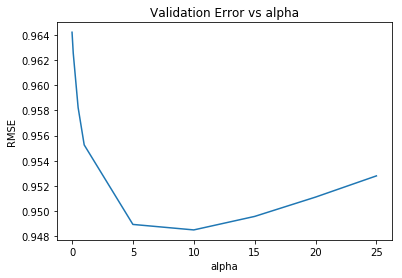

In [21]:
alphas = [0.001, 0.1, 0.5, 1, 5, 10, 15, 20, 25]
cv_ridge_rmse = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

series_ridge = pd.Series(cv_ridge_rmse, index = alphas)
plot_rmse_param(series_ridge, "alpha")

Observe a curva em forma de U acima. Quando o alpha é muito grande, a regularização é muito forte e o modelo não consegue capturar todas as complexidades dos dados - o erro volta a aumentar. Se, no entanto, deixarmos o modelo ser muito flexível (alpha pequeno), o modelo tende ao overfitting. Um valor de alpha = 10 parece o melhor, com base no gráfico acima.

In [22]:
best_rmse_ridge, best_param_ridge = best_rmse_param(series_ridge)

model_ridge = Ridge(alpha = best_param_ridge)
score_ridge = train_model(model_ridge, True)

          282           281          280          279           278
-0.03342 x   + 0.03221 x   + 0.1623 x   + 0.4176 x   - 0.06072 x  
          277           276           275           274           272
 + 0.123 x   + 0.05883 x   + 0.05326 x   - 0.05237 x   - 0.06134 x  
            271           269          268           267           266
 - 0.05753 x   + 0.07463 x   - 0.2163 x   + 0.03609 x   + 0.05175 x  
           265          263           262          261          256
 + 0.1251 x   + 0.0938 x   - 0.03709 x   - 0.1137 x   - 0.2296 x  
           255           253          252           251           250
 + 0.2181 x   - 0.06499 x   - 0.1196 x   + 0.06491 x   + 0.08762 x  
             249         248           247          246          245
 + 0.002794 x   - 0.091 x   - 0.01544 x   - 0.1223 x   - 0.2494 x  
            244          243           241           239           237
 - 0.07407 x   - 0.2213 x   - 0.07527 x   + 0.07076 x   - 0.05725 x  
           236          235      

In [23]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)
print("Ridge escolheu " + str(sum(coef != 0)) + " variáveis and eliminou as outras " +  str(sum(coef == 0)) + " variáveis.")

Ridge escolheu 227 variáveis and eliminou as outras 56 variáveis.


#### Avaliando o modelo de regressão Ridge

In [24]:
print u"Modelo Ridge, com os dados de 2006 e 2010: \nAlpha = {0} \nRMSE = {1} \nScore = {2}".format(best_param_ridge, best_rmse_ridge, score_ridge)

Modelo Ridge, com os dados de 2006 e 2010: 
Alpha = 10.0 
RMSE = 0.948498584638 
Score = 0.706476423746


Os resíduos do modelo, isto é, a diferença entre o valor real e o valor previsto pelo modelo pode ser visto no gráfico abaixo.

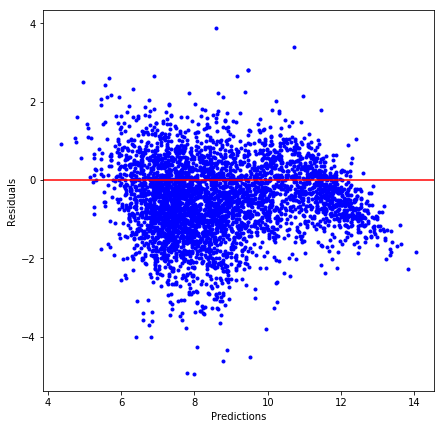

In [25]:
plot_res_vs_pred(model_ridge)

Como os resíduos estão aleatoriamente distribuídos e próximos de 0, ou seja, o erro na predição está pequeno, podemos concluir que o modelo está adequado ao problema.

#### Avaliando o modelo com os dados de 2014

In [26]:
model_ridge_2014 = Ridge(alpha = best_param_ridge)
score_ridge_2014, rmse_ridge = train_model_2014(model_ridge_2014)

print u"Modelo Ridge, treinado com os dados de 2006 e 2010 e testado com os de 2014: \nAlpha = {0} \nRMSE = {1} \nScore = {2}".format(best_param_ridge, rmse_ridge, score_ridge_2014)

Modelo Ridge, treinado com os dados de 2006 e 2010 e testado com os de 2014: 
Alpha = 10.0 
RMSE = 1.68830685772 
Score = 0.563685149105


### 2.3 Modelo Lasso

Lasso é um modelo de regressão similar ao modelo anterior Ridge, onde a sua função de perda ($L$) contém outro elemento que deve ser minimizado também. Este outro elemento, porém, é o valor absoluto dos parâmetros estimados para cada variável. O $\alpha$ é um escalar que deve ser aprendido, a fim de encontrar o melhor valor que se encaixa aos dados, como será feito mais a frente.

$$L = ∑( Ŷ_{i}– Y_{i})² + \alpha∑ |β|$$

#### Implementando o modelo de regressão Lasso

In [27]:
model_lasso = Lasso(max_iter = 10000)
train_model(model_lasso, True)

        11
0.4889 x  + 3.859


0.5774209161101116

#### Ajuste dos parâmetros do modelo de regressão Lasso

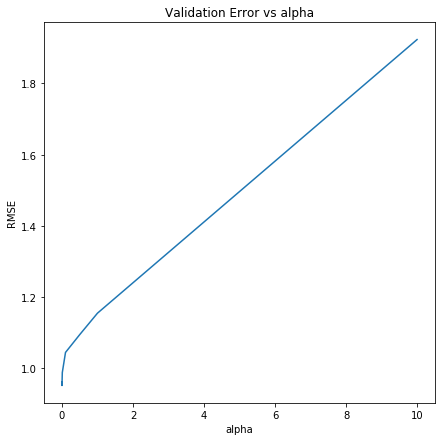

In [28]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
cv_lasso_rmse = [rmse_cv(Lasso(alpha = alpha, max_iter = 10000)).mean() 
            for alpha in alphas]

series_lasso = pd.Series(cv_lasso_rmse, index = alphas)
plot_rmse_param(series_lasso, "alpha")

In [29]:
best_rmse_lasso, best_param_lasso = best_rmse_param(series_lasso)

model_lasso = Lasso(alpha = best_param_lasso, max_iter = 10000)
score_lasso = train_model(model_lasso, True)

        279           265           246          245           244
0.4491 x   + 0.02559 x   - 0.06113 x   - 0.2067 x   - 0.01616 x  
           243          236           235          231          226
 - 0.1514 x   + 0.3593 x   - 0.09751 x   - 0.3176 x   - 0.0233 x  
             225           224          219          218           211
 + 0.005331 x   - 0.08989 x   + 0.1276 x   + 0.2306 x   + 0.01244 x  
           202          201           194          185           168
 + 0.4077 x   + 0.4655 x   - 0.06094 x   + 0.2686 x   + 0.06156 x  
           166            160          155          154          138
 - 0.5152 x   + 0.008932 x   - 0.1872 x   + 0.1164 x   + 0.6039 x  
           135           132           131          125        118
 - 0.3309 x   - 0.01917 x   + 0.07766 x   + 0.5229 x   - 0.12 x  
           116          104           100           99           92
 + 0.0286 x   - 0.1462 x   + 0.05943 x   + 0.01609 x  - 0.05115 x 
           91            89           88         

In [30]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso escolheu " + str(sum(coef != 0)) + " variáveis and eliminou as outras " +  str(sum(coef == 0)) + " variáveis.")

Lasso escolheu 102 variáveis and eliminou as outras 181 variáveis.


#### Avaliando o modelo de regressão Lasso

In [31]:
print u"Modelo Lasso, com os dados de 2006 e 2010: \nAlpha = {0} \nRMSE = {1} \nScore = {2}".format(best_param_lasso, best_rmse_lasso, score_lasso)

Modelo Lasso, com os dados de 2006 e 2010: 
Alpha = 0.001 
RMSE = 0.95081049194 
Score = 0.706009386726


Os resíduos do modelo, isto é, a diferença entre o valor real e o valor previsto pelo modelo pode ser visto no gráfico abaixo.

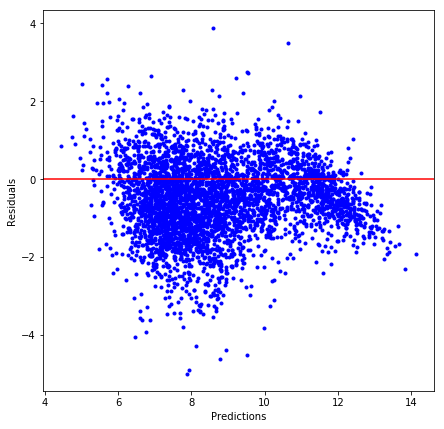

In [32]:
plot_res_vs_pred(model_lasso)

Como os resíduos estão aleatoriamente distribuídos e próximos de 0, ou seja, o erro na predição está pequeno, podemos concluir que o modelo está adequado ao problema.

#### Avaliando o modelo com os dados de 2014

In [33]:
model_lasso_2014 = Lasso(alpha = best_param_lasso, max_iter = 10000)
score_lasso_2014, rmse_lasso = train_model_2014(model_lasso_2014)

print u"Modelo Lasso, treinado com os dados de 2006 e 2010 e testado com os de 2014: \nAlpha = {0} \nRMSE = {1} \nScore = {2}".format(best_param_lasso, rmse_lasso, score_lasso_2014)

Modelo Lasso, treinado com os dados de 2006 e 2010 e testado com os de 2014: 
Alpha = 0.001 
RMSE = 1.686145969 
Score = 0.564801325905


### 2.4 Modelo K-NN

O modelo de regressão k-NN é baseado nos k vizinhos mais próximos, ou seja, o valor alvo é previsto pela interpolação local dos valores alvos associados aos vizinhos mais próximos no conjunto de treinamento. Portanto, o melhor valor de k deve ser encontrado para o nosso conjunto de dados.

#### Implementando o modelo de regressão K-NN

In [34]:
model_knn = KNeighborsRegressor()
train_model(model_knn, False)

0.6892855834266522

#### Ajuste dos parâmetros do modelo de regressão K-NN

A quantidade de vizinhos (k) é o parâmetro mais importante do algoritmo K-NN e define a quantidade de valores vizinhos de cada valor de entrada que o algoritmo deve considerar para estimar a saída. Por isso, usaremos cross-validation para encontrar o melhor valor deste parâmetro.

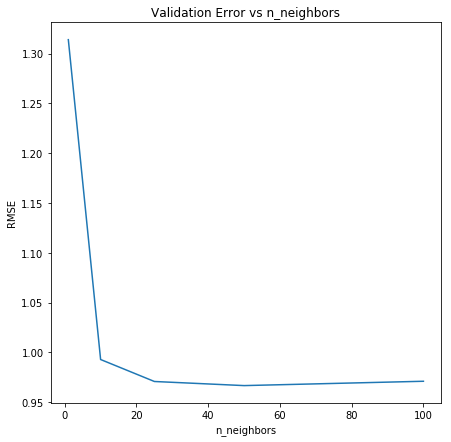

In [35]:
n_neighbors = [1, 10, 25, 50, 100]
cv_knn_rmse = [rmse_cv(KNeighborsRegressor(n_neighbors = n)).mean() 
            for n in n_neighbors]

series_knn = pd.Series(cv_knn_rmse, index = n_neighbors)
plot_rmse_param(series_knn, "n_neighbors")

In [36]:
best_rmse_knn, best_param_knn = best_rmse_param(series_knn)

model_knn = KNeighborsRegressor(n_neighbors = best_param_knn)
score_knn = train_model(model_knn, False)

#### Avaliando o modelo de regressão K-NN

In [37]:
print u"Modelo K-NN, com os dados de 2006 e 2010: \nNeighbors = {0} \nRMSE = {1} \nScore = {2}".format(best_param_knn, best_rmse_knn, score_knn)

Modelo K-NN, com os dados de 2006 e 2010: 
Neighbors = 50 
RMSE = 0.966658000264 
Score = 0.70819441125


Os resíduos do modelo, isto é, a diferença entre o valor real e o valor previsto pelo modelo pode ser visto no gráfico abaixo.

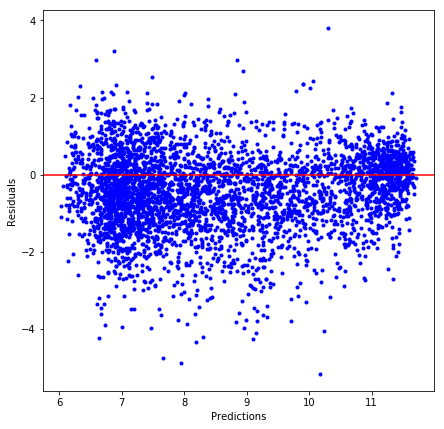

In [38]:
plot_res_vs_pred(model_knn)

Como os resíduos estão aleatoriamente distribuídos e próximos de 0, ou seja, o erro na predição está pequeno, podemos concluir que o modelo está adequado ao problema.

#### Avaliando o modelo com os dados de 2014

In [39]:
model_knn_2014 = KNeighborsRegressor(n_neighbors = best_param_knn)
score_knn_2014, rmse_knn = train_model_2014(model_knn_2014)

print u"Modelo K-NN, treinado com os dados de 2006 e 2010 e testado com os de 2014: \nNeighbors = {0} \nRMSE = {1} \nScore = {2}".format(best_param_knn, rmse_knn, score_knn_2014)

Modelo K-NN, treinado com os dados de 2006 e 2010 e testado com os de 2014: 
Neighbors = 50 
RMSE = 1.79783849492 
Score = 0.505235447775


### 2.5 Modelo SVR (Suport Vector Regression)

#### Implementando o modelo SVR

In [40]:
model_svr = SVR()
train_model(model_svr, False)

0.7089499381621422

#### Ajuste dos parâmetros do modelo SVR

O C é um parâmetro de penalidade do termo do erro, importante no SVR, porque se for muito grande poderemos ter overffiting ou underffiting, caso contrário. Por isso, tentaremos encontrar o seu melhor valor.

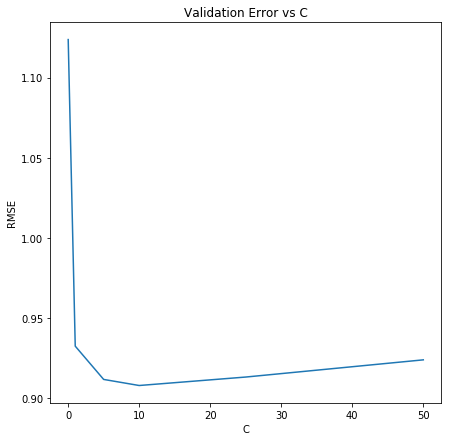

In [41]:
cs = [0.01, 1, 5, 10, 25, 50]
cv_svr_rmse = [rmse_cv(SVR(C = c)).mean() 
            for c in cs]

series_svr = pd.Series(cv_svr_rmse, index = cs)
plot_rmse_param(series_svr, "C")

In [42]:
best_rmse_svr, best_param_svr = best_rmse_param(series_svr)

model_svr = SVR(C = best_param_svr)
score_svr = train_model(model_svr, False)

#### Avaliando o modelo de regressão SVR

In [43]:
print u"Modelo SVR, com os dados de 2006 e 2010: \nC = {0} \nRMSE = {1} \nScore = {2}".format(best_param_svr, best_rmse_svr, score_svr)

Modelo SVR, com os dados de 2006 e 2010: 
C = 10.0 
RMSE = 0.907917984996 
Score = 0.749810274926


Os resíduos do modelo, isto é, a diferença entre o valor real e o valor previsto pelo modelo pode ser visto no gráfico abaixo.

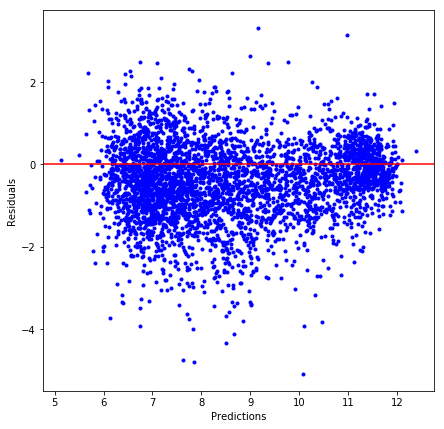

In [44]:
plot_res_vs_pred(model_svr)

Como os resíduos estão aleatoriamente distribuídos e próximos de 0, ou seja, o erro na predição está pequeno, podemos concluir que o modelo está adequado ao problema.

#### Avaliando o modelo com os dados de 2014

In [45]:
model_svr_2014 = SVR(C = best_param_svr)
score_svr_2014, rmse_svr = train_model_2014(model_svr_2014)

print u"Modelo SVR, treinado com os dados de 2006 e 2010 e testado com os de 2014: \nC = {0} \nRMSE = {1} \nScore = {2}".format(best_param_svr, rmse_svr, score_svr_2014)

Modelo SVR, treinado com os dados de 2006 e 2010 e testado com os de 2014: 
C = 10.0 
RMSE = 1.71746902419 
Score = 0.548482016736


### 2.6 Modelo RF (Random Forest)

Random Forest é um algoritmo que ajusta várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. A quantidade de árvores (n_estimators) é um parâmetro, cujo valor, deve ser encontrado, para que o modelo melhor represente os dados.

#### Implementando o modelo de regressão RF

In [46]:
model_rf = RandomForestRegressor()
train_model(model_rf, False)

0.6851091916116145

#### Ajuste dos parâmetros do modelo de regressão RF

Um dos parâmetros mais importantes do Random Forest é a quantidade de estimadores, que representam a quantidade de árvores usadas no modelo. Em geral, quanto maior melhor o desempenho do modelo, porém mais memória é necessário.

Abaixo, encontramos o melhor valor dado um intervalo de 1 à 1000.

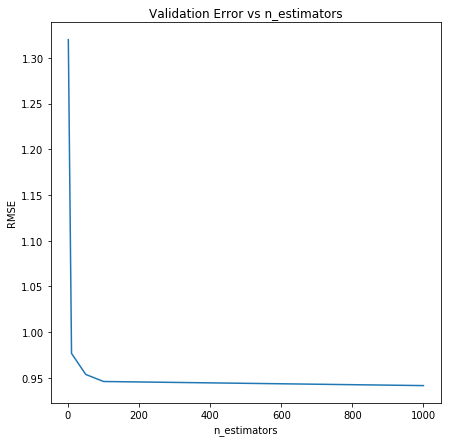

In [47]:
n_estimators = [1, 10, 50, 100, 1000]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n)).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [48]:
best_rmse_rf, best_param_rf = best_rmse_param(series)

model_rf = RandomForestRegressor(n_estimators = best_param_rf)
score_rf = train_model(model_rf, False)

#### Avaliando o modelo de regressão RF

In [49]:
print u"Modelo RF, com os dados de 2006 e 2010: \nEstimators = {0} \nRMSE = {1} \nScore = {2}".format(best_param_rf, best_rmse_rf, score_rf)

Modelo RF, com os dados de 2006 e 2010: 
Estimators = 1000 
RMSE = 0.941525652992 
Score = 0.700662471686


Os resíduos do modelo, isto é, a diferença entre o valor real e o valor previsto pelo modelo pode ser visto no gráfico abaixo.

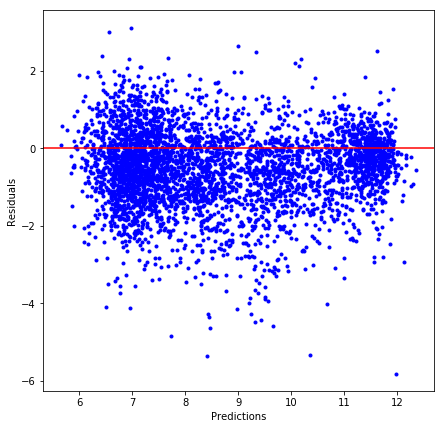

In [50]:
plot_res_vs_pred(model_rf)

Como os resíduos estão aleatoriamente distribuídos e próximos de 0, ou seja, o erro na predição está pequeno, podemos concluir que o modelo está adequado ao problema.

#### Avaliando o modelo com os dados de 2014

In [51]:
model_rf_2014 = RandomForestRegressor(n_estimators = best_param_rf)
score_rf_2014, rmse_rf = train_model_2014(model_rf_2014)

print u"Modelo RF, treinado com os dados de 2006 e 2010 e testado com os de 2014: \nEstimators = {0} \nRMSE = {1} \nScore = {2}".format(best_param_rf, rmse_rf, score_rf_2014)

Modelo RF, treinado com os dados de 2006 e 2010 e testado com os de 2014: 
Estimators = 1000 
RMSE = 1.79795798661 
Score = 0.505169677442


## 3. Conclusões

Neste notebook, foram implementados alguns modelos de regressão, com e sem regularização, capazes de prever a quantidade de votos de um candidato nas eleições. Os dados utilizados foram pré-processados, normalizando e corrigindo os valores ausentes, por exemplo, e depois foram encontrados os melhores parâmetros para cada modelo com cross-validation.

Os modelos foram inicialmente treinados com os dados das eleições de 2006 e 2010 como treino e validação, respectivamente, e posteriormente foram utilizados os dados de 2006 e 2010 como treino e o de 2014 como teste.

No gráfico abaixo estão apresentados os RMSEs para cada modelo.

   model      RMSE        R2
0  lasso  1.686146  0.564801
1  ridge  1.688307  0.563685
2    svr  1.717469  0.548482
3    knn  1.797838  0.505235
4     rf  1.797958  0.505170


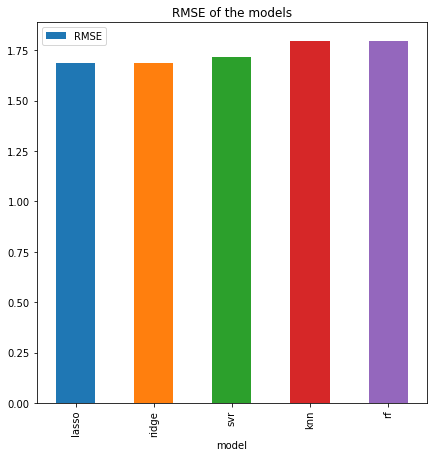

In [52]:
labels = ["model","RMSE","R2"]
results = []
results.append(["lasso", rmse_lasso, score_lasso_2014])
results.append(["ridge", rmse_ridge, score_ridge_2014])
results.append(["svr", rmse_svr, score_svr_2014])
results.append(["knn", rmse_knn, score_knn_2014])
results.append(["rf", rmse_rf, score_rf_2014])

df_model_rmse_r2 = pd.DataFrame.from_records(results, columns=labels)
print(df_model_rmse_r2)

df_model_rmse_r2.plot.bar(x = 'model', y = 'RMSE', title = "RMSE of the models")

Os modelos com menores RMSE foram Ridge o Lasso, sendo este último com um valor ligeiramente menor. A principal razão para estes modelos terem conseguido os menores erros é a eliminação de variáveis que não são relevantes para o modelo. Assim, considerando somente as variáveis que são mais importantes, os modelos não especializam-se nos dados e têm um maior poder de generalização, prevendo novos valores com mais precisão.

Analisamos também, no gráfico mais abaixo, o R2, que mostra a explicabilidade das variáveis independentes em relação à variável alvo votos, neste caso. Percebe-se que os modelos Ridge e Lasso também aprensentam os melhores valores em relação aos outros modelos aqui analisados.

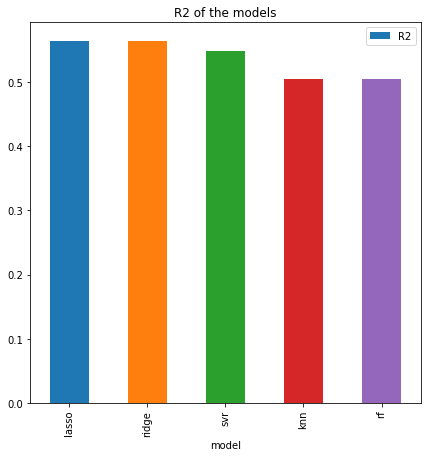

In [53]:
df_model_rmse_r2.plot.bar(x = 'model', y = 'R2', title = "R2 of the models")

## 4. Referências

https://www.kaggle.com/apapiu/regularized-linear-models

https://codingstartups.com/practical-machine-learning-ridge-regression-vs-lasso/